In [1]:
# 数据分析/处理
import numpy as np
import pandas as pd
import re

# 搭建神经网络
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch import optim
from torch.utils.data import Dataset,DataLoader

# 数据可视化
import matplotlib.pyplot as plt
import warnings

# word2vec
from gensim.models import Word2Vec


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# 验证cuda是否可用
cuda_available=torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
if cuda_available:
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Compute Capability:", torch.cuda.get_device_capability(0))
# 宇宙的答案
np.random.seed(42)
torch.manual_seed(42)

### 数据集  
这里使用的数据集是斯坦福大学提供的SNLI数据集，这个数据集中有两种可以处理的数据类型。  
+ json
+ txt

在本数据集中，两类文件部分内容有差异，但是我们所需要的两个句子和标签在两类文件中是完全一样的。也就是说，我们仅需要载入json或者txt两种格式中的一种来进行训练。

In [4]:
# use txt
# train=pd.read_csv("snli_1.0\snli_1.0_train.txt",delimiter='\t')
# use json
train=pd.read_json("snli_1.0\snli_1.0_train.jsonl",lines=True)
train=pd.concat([train["gold_label"],train["sentence1"],train["sentence2"]],axis=1)
train.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


In [5]:
dev=pd.read_json("snli_1.0\snli_1.0_dev.jsonl",lines=True)
dev=pd.concat([dev["gold_label"],dev["sentence1"],dev["sentence2"]],axis=1)
dev.head()

,gold_label,sentence1,sentence2
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.
3,entailment,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.
4,neutral,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.


In [6]:
test=pd.read_json("snli_1.0\snli_1.0_test.jsonl",lines=True)
test=pd.concat([test["gold_label"],test["sentence1"],test["sentence2"]],axis=1)
test.head()

,gold_label,sentence1,sentence2
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.


### tokenizer

In [7]:
# from task1.ipynb
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

def tokenization_to_ngram(sentence,n=1):
    '''
    将句子转化为token,去除停止词,并返回用于n-gram语言建模的特征
    '''
    stop_words = set(stopwords.words('english'))
    # print(type(sentence))
    words = re.sub("[^\w]", " ",  sentence).split() 
    filtered_sentence=[w.lower() for w in words if not w in stop_words]
    output=[]
    if(n!=1):
        if(len(filtered_sentence)<n):
            # 对于n>len(filtered_sentence)的情况，直接将句子中所有的词拼接
            tmp=''
            for i in range(len(filtered_sentence)):
                tmp=tmp+filtered_sentence[i]
            output.append(tmp)
            return output
        else:
            # 对于其他情况，将句子分解为n个词一份
            for i in range(len(filtered_sentence)-n+1):
                # 这一步是将n个单词拼在一起作为一个单词，这样的话可以视作一个单词，方便一会儿进行哈希
                tmp=filtered_sentence[i]
                for t in range(1,n):
                    tmp+=filtered_sentence[i+t]
                output.append(tmp)
            return output
    else:
        return filtered_sentence


In [8]:
train_sen1=train["sentence1"].apply(tokenization_to_ngram,n=1).to_list()
train_sen2=train["sentence2"].apply(tokenization_to_ngram,n=1).to_list()
dev_sen1=dev["sentence1"].apply(tokenization_to_ngram,n=1).to_list()
dev_sen2=dev["sentence2"].apply(tokenization_to_ngram,n=1).to_list()
test_sen1=test["sentence1"].apply(tokenization_to_ngram,n=1).to_list()
test_sen2=test["sentence2"].apply(tokenization_to_ngram,n=1).to_list()

In [9]:
sentence_list=train_sen1+train_sen2\
    +dev_sen1+dev_sen2\
    +test_sen1+test_sen2
print(sentence_list[0])
len(sentence_list)

['a', 'person', 'horse', 'jumps', 'broken', 'airplane']


1140304

In [10]:
# 使用word2vec时，需要先将句子输入做训练
model1=Word2Vec(sentence_list,vector_size=50,sg=1)
model1.vector_size

50

In [11]:
maxSenLen=0
for i in sentence_list:
    maxSenLen=max(maxSenLen,len(i))
print(maxSenLen)

46


In [12]:
def sen2word2vec(sentence_list,model=model1,maxlen=maxSenLen):
    # 因为在处理两个句子时会使用到池化，所以我们不需要对齐句子的长度
    # vecList=np.zeros((maxlen,model.vector_size)) 
    vecList=np.zeros((len(sentence_list),model.vector_size)) 
    
    if(sentence_list==[]):
        return vecList 
    # 将列表句子转化为稠密词向量句子
    # vecList=np.array([])
    for i,e in enumerate(sentence_list):
        if(e in model.wv):
            vecList[i]=model.wv[e]
    return vecList

s=['a','good','kjell']
# print(model1.wv[s])
p=sen2word2vec(s,model1)
print(len(p))
print(p[0]==model1.wv['a'])

3
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


### 语句关系推断

task3要求判断输入的两个句子之间的关系。两个句子之间的关系有以下三类：

+ neutral(N):中性
+ contradiction(C):冲突、相反
+ entailment(E):蕴含  

本项目中的实现主要参考了以下两个参考资料
+ Enhanced LSTM for Natural Language Inference(ESIM)：使用特殊设计的LSTM进行推断
+ Reasoning about Entailment with Neural Attention：使用attention机制进行推断，提出了two-way-attention（双向注意力机制）

ESIM流程可以概括为：
1. 先使用一个LSTM学习两个句子的特征
2. 随后进行对特征进行点乘、做差等处理，相当于特征工程
3. 输入另一个LSTM中对其两个句子之间的关系进行判断
  
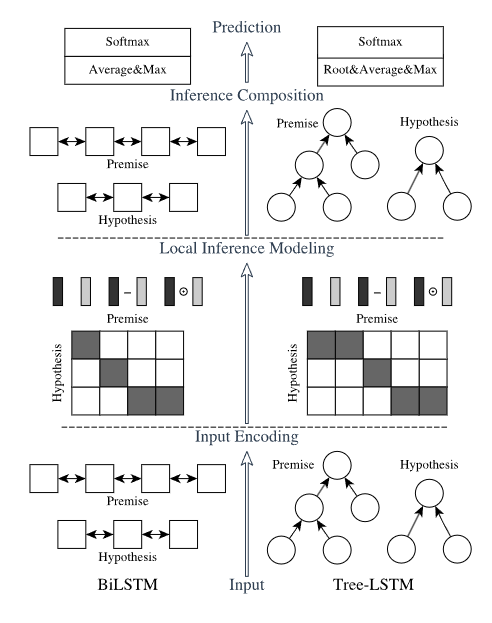

在ESIM中加入双向的token-to-token的注意力机制，就是要在第二步的时候使用注意力机制代替原来的局部推理建模 Local Inference Modeling。




### 定义模型

In [3]:

class LSTM(nn.Module):
    def __init__(self,d_model,hidden_size,num_layer,output_size=50,dropout=0.1,bid=False) -> None:
        super().__init__()
        self.d_model=d_model
        self.hidden_size=hidden_size
        self.layer=num_layer
        self.bid=bid
        
        self.rnn=nn.LSTM(d_model,hidden_size,num_layer,\
                        batch_first=True,dropout=dropout,bidirectional=bid)
        # self.classfier=nn.Sequential(
        #     nn.Linear(hidden_size,output_size),
        #     nn.ReLU(),
        #     nn.Softmax(output_size)
        # )

    def forward(self,X):
        if(self.bid==True):
            h0=torch.zeros(2*self.layer,X.size(0),self.hidden_size).to(device)
            c0=torch.zeros(2*self.layer,X.size(0),self.hidden_size).to(device)
        else:
            h0=torch.zeros(self.layer,X.size(0),self.hidden_size).to(device)
            c0=torch.zeros(self.layer,X.size(0),self.hidden_size).to(device)
        X,(hn,cn)=self.rnn(X,(h0,c0))
        # out=self.classfier(X[:,-1,:])
        return X,hn,cn

tmp=torch.ones(3,4,5)
exam=LSTM(5,5,1,6,bid=True)
a,b,c=exam(tmp)
print(a.size())
print(b.size())
print(c.size())



torch.Size([3, 4, 10])
torch.Size([2, 3, 5])
torch.Size([2, 3, 5])


### token2token的双向注意力机制

在这个任务中，我们有两个句子A和B，我们的任务是判断A是否在逻辑上蕴含B。

token2token的注意力机制是先使用LSTM学习A的表征，然后和B的每一个token都做一个attention，并且每个词都需要加入前一个词的attention值

双向的注意力机制则是从BiLSTM得到启发，不仅要计算从A到B的token2token注意力分数，还要计算B到A的注意力分数

假设由LSTM产生的A句子的表征为$Y \in R^{K \times L} $，其中L为句子A的长度，K为特征向量的维度。$h_t$表示LSTM对B句子中的第t个token的输出，$h_n$表示在LSTM处理句子B后得到的最后的输出n为句子B的长度，$e_L$表示A句子最后输出的特征向量，$r_{t-1}$表示t-1时刻的attention值。  
由此，我们可以看到token2token的注意力机制的公式为：

$$
M_t=\tanh (W_{y}Y+(W_{h}h_t+W_{r}r_{t-1}) \otimes e_L ) \\
a_t=softmax(w^TM_t) \\
r_t=Ya_{t}^{T}+\tanh(W_tr_{t-1}) \\
h^*=\tanh(W_pr_N+W_xh_n)
$$

而双向的注意力机制，则是将这两个句子的位置调换。其实就是把两句话交换位置再计算一次（虽然效果并不好）。

参考资料：
[Enhanced LSTM for Natural Language Inference](https://arxiv.org/abs/1609.06038)
[用注意力机制进行句子蕴含推理](https://zhuanlan.zhihu.com/p/40562196)


In [43]:
class ESIM(nn.Module):
    def __init__(self,d_model=50,hidden_size=50):
        super().__init__()

        self.D=d_model
        self.K=hidden_size
        self.encoder1=LSTM(d_model=self.D,hidden_size=self.K,num_layer=1,bid=True)
        self.tan=nn.Tanh()
        self.softmax=nn.Softmax(dim=-1)
        # self.encoder2=nn.Sequential(
        #     LSTM(d_model=self.D,hidden_size=self.K,bid=True),
        #     nn.AvgPool2d(),
        #     nn.MaxPool2d()
        # )
        # self.cls=nn.Sequential(
        #     nn.Linear(),
        #     nn.ReLU(),
        #     nn.Linear(),
        #     nn.Softmax(3)
        # )
    
        self.W1=nn.ModuleList([
            # W_y
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_h
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_r
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_t
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_p
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_x
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # w^T
            nn.Linear(in_features=2*self.K,out_features=1,bias=False)
        ])
        self.W2=nn.ModuleList([
            # W_y
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_h
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_r
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_t
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_p
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # W_x
            nn.Linear(in_features=2*self.K,out_features=2*self.K,bias=False),
            # w^T
            nn.Linear(in_features=2*self.K,out_features=1,bias=False)
        ])

    def T2TAtt(self,s1,s2,w=1):
        a,b,c=s1.size()
        if(w==1):
            M1=self.tan(self.W1[0](s1)+torch.mul(self.W1[1](s2[:,0,:]),s1[:,-1,:]).view(a,1,c))
            a1=self.softmax(self.W1[6](M1))
            # print(s1.size())
            _,p,q=a1.size()
            # print(a1.size())
            a1=a1.view(a,q,p)
            # print(a1.size())            
            rt=a1@s1
            # print(rt.size())
            for i in range(s2.size(1)): 
                M1=self.tan(self.W1[0](s1)+torch.mul(self.W1[1](s2[:,i,:]).view(a,1,c)+self.W1[2](rt),s1[:,-1,:].view(a,1,c)))
                a1=self.softmax(self.W1[6](M1))
                a1=a1.view(a,q,p)
                # h.size()=10,1,100 
                rt=a1@s1+self.softmax(self.W1[3](rt))
            # h.size()=10,1,100
            h=self.tan(self.W1[4](rt)+self.W1[5](s2[:,-1,:]).view(a,1,c))
        else:
            M1=self.tan(self.W2[0](s1)+torch.mul(self.W2[1](s2[:,0,:]),s1[:,-1,:]).view(a,1,c))
            a1=self.softmax(self.W2[6](M1))
            # print(s1.size())
            _,p,q=a1.size()
            # print(a1.size())
            a1=a1.view(a,q,p)
            # print(a1.size())            
            rt=a1@s1
            # print(rt.size())
            for i in range(s2.size(1)): 
                M1=self.tan(self.W2[0](s1)+torch.mul(self.W2[1](s2[:,i,:]).view(a,1,c)+self.W2[2](rt),s1[:,-1,:].view(a,1,c)))
                a1=self.softmax(self.W2[6](M1))
                a1=a1.view(a,q,p)
                # h.size()=10,1,100 
                rt=a1@s1+self.softmax(self.W2[3](rt))
            # h.size()=10,1,100
            h=self.tan(self.W2[4](rt)+self.W2[5](s2[:,-1,:]).view(a,1,c))

        return h

    def forward(self,s1,s2):
        # encoder
        f1,_,_=self.encoder1(s1)
        f2,_,_=self.encoder1(s2)
        # 2 way t2t att
        h1=self.T2TAtt(f1,f2,w=1)
        h2=self.T2TAtt(f2,f1,w=2)
        # cls
        # v1=self.encoder2(h1)
        # v2=self.encoder2(h2)
        # V=torch.concat([v1,v2],dim=-1)
        # output=self.cls(V)
        return h1,h2

A=torch.ones((10,5,50))
B=torch.ones((10,3,50))
es=ESIM()

h1,h2=es(A,B)
print(h1.size())
print(h2.size())

torch.Size([10, 1, 100])
torch.Size([10, 1, 100])


### 数据集

In [ ]:
class MyDataset(Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        return 

    